# Competition background
**<font size=4>Enefit - Predict Energy Behavior of Prosumers**  
    The goal of the competition is to create an energy prediction model of prosumers to reduce energy imbalance costs.  
    This competition aims to tackle the issue of energy imbalance, a situation where the energy expected to be used doesn't line up with the actual energy used or produced. Prosumers, who both consume and generate energy, contribute a large part of the energy imbalance. Despite being only a small part of all consumers, their unpredictable energy use causes logistical and financial problems for the energy companies.

# progress
## Previous progress
1 进行了各变量对target的分析，得出结论eic_count, installed_capacity, lowest_price_per_mwh, highest_price_per_mwh, euros_per_mwh, temperature, dewpoint, cloudcover_low, cloudcover_total, forecast_datetime, direct_solar_radiation, surface_solar_radiation_downwards, snowfall这些变量对target的关系比较强。  
2 运用xgboost模型分别对筛选后的变量和未筛选的变量进行训练，得到未筛选的测试集MAE 90， 筛选后的MAE 89，上传到kaggle122分，由于xgboost是基于树的模型，特征筛选对模型用处不大，之后的实验都不再筛选特征。
## Current progress
1 考察了target数据的周期性，之前只用了过去第2天的target，新增过去3、4、5、6、7、14天的target作为新特征。  
2 数据中15个county来源于一个比较小的国家，因此全国的天气状况也会对当地的target产生一定影响，构造所有county的天气数据平均数作为新特征。  
3 使用ligthGBM模型，训练速度远快于xgboost，并且训练新增特征数据的误差小于xgboost。
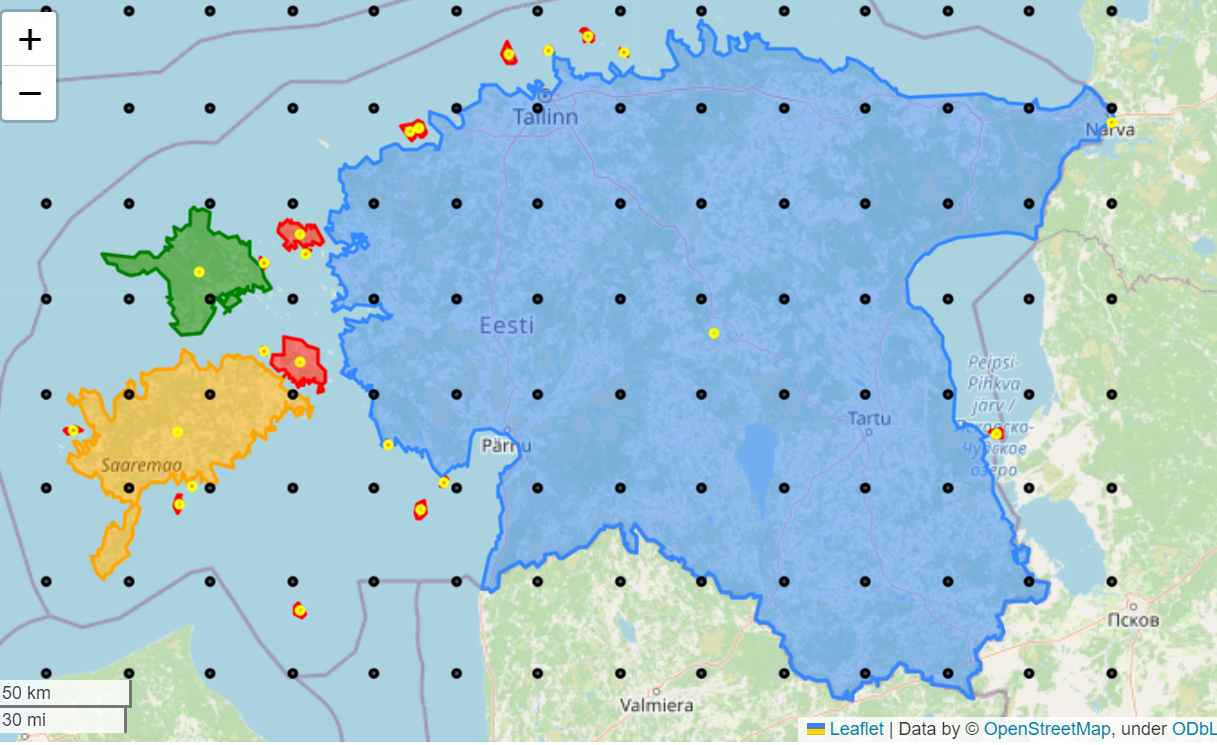

# Data processing

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import pickle
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
import lightgbm as lgb
from functools import reduce
from sklearn.metrics import mean_absolute_error
import os
import seaborn as sns

In [2]:
root_path = '../data/'

## Data visualization

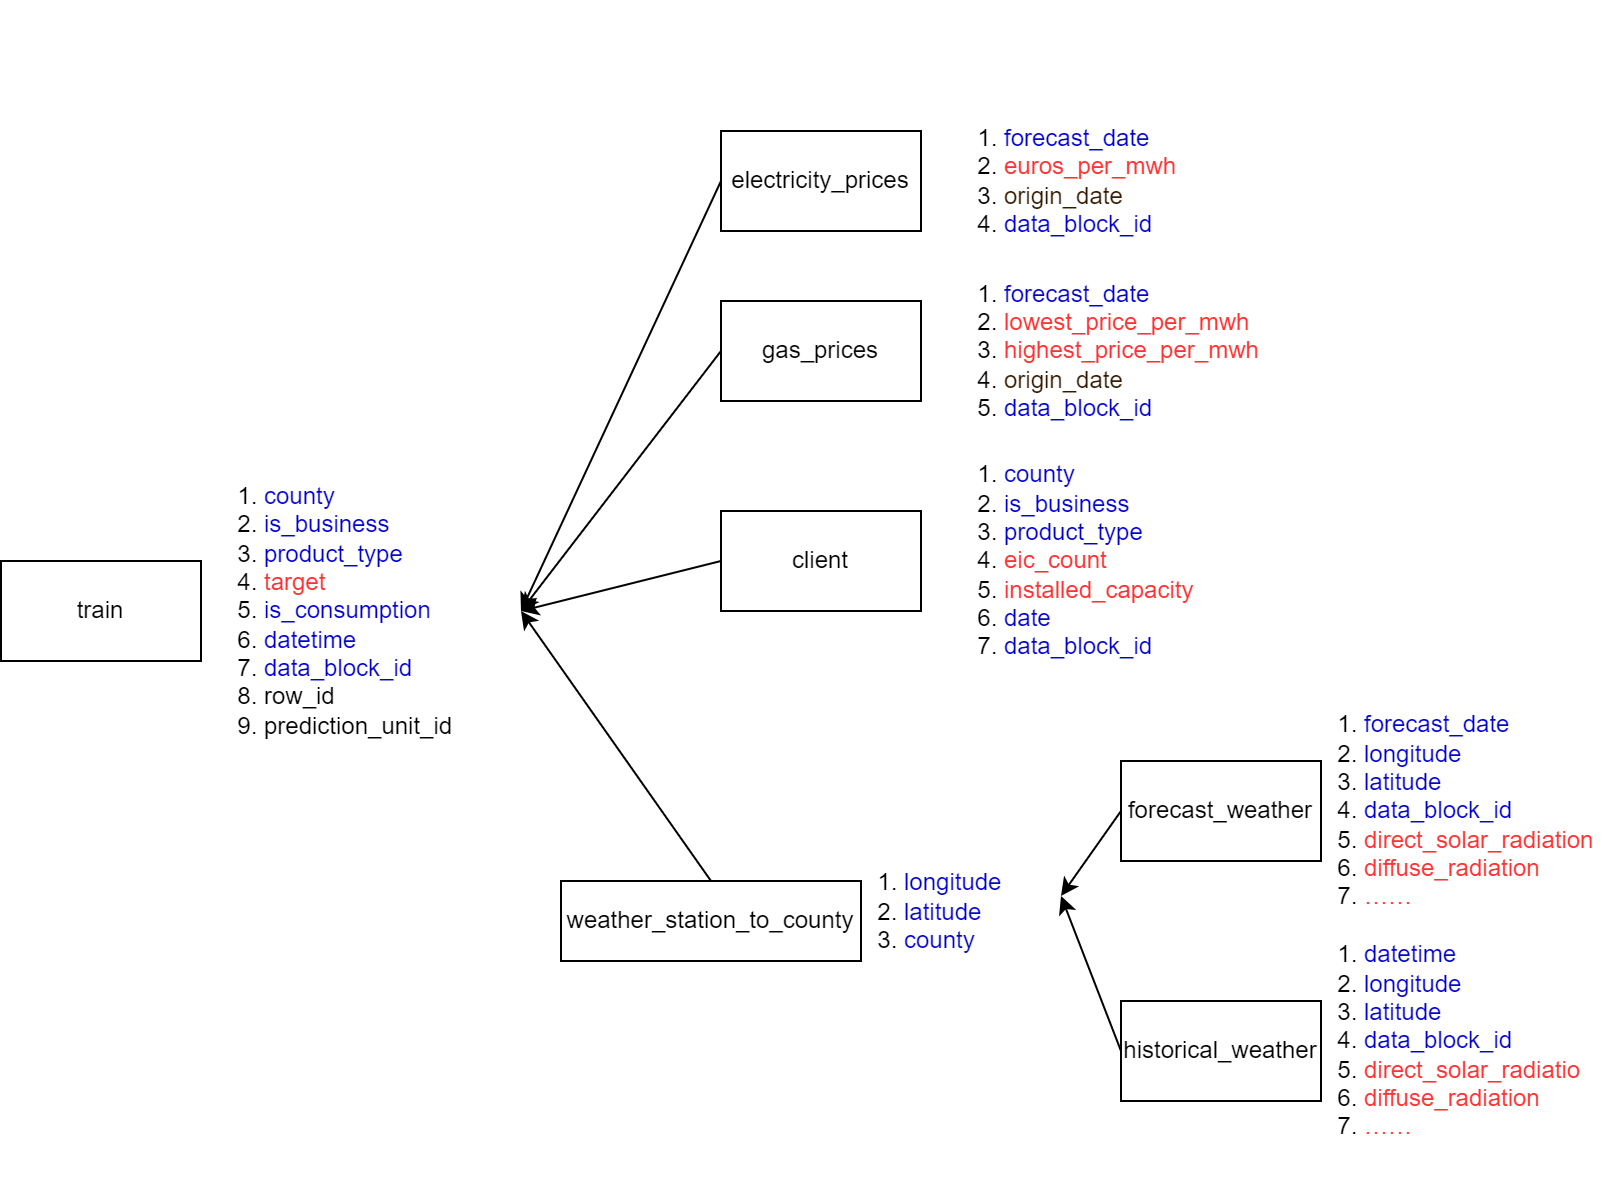

In [3]:
train = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'])
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


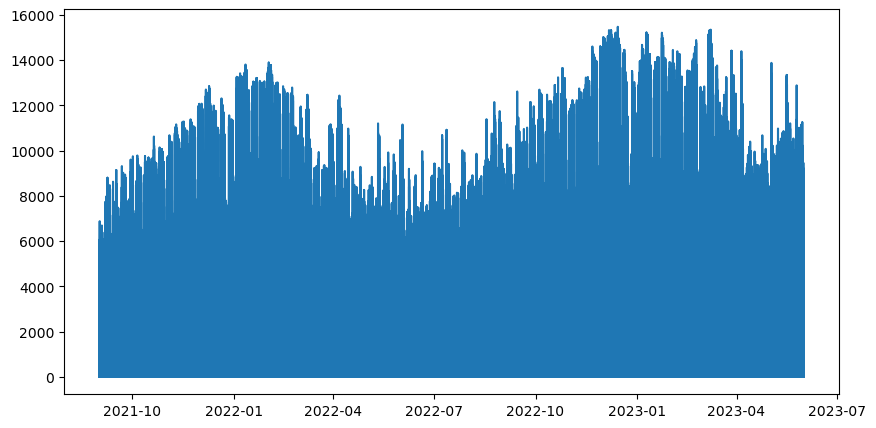

In [4]:
# target时序图
train_show = train[(train['is_business'] == 0) & (train['is_consumption'] == 1) & (train['county']) == 0 & (train['product_type'] == 1)]
figure = plt.figure(figsize=(10, 5))
plt.plot('datetime', 'target', data=train_show)

In [5]:
train_show = train_show.set_index('datetime')

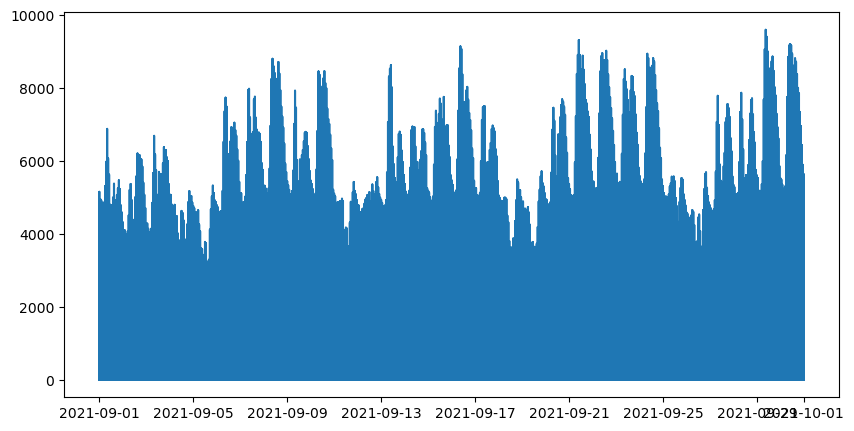

In [6]:
# 放大到一个月
train_month = train_show.loc[pd.date_range('2021-9-1', '2021-10-1', freq='H')]
plt.figure(figsize=(10, 5))
plt.plot(train_month.index, train_month['target'])

<Axes: ylabel='target'>

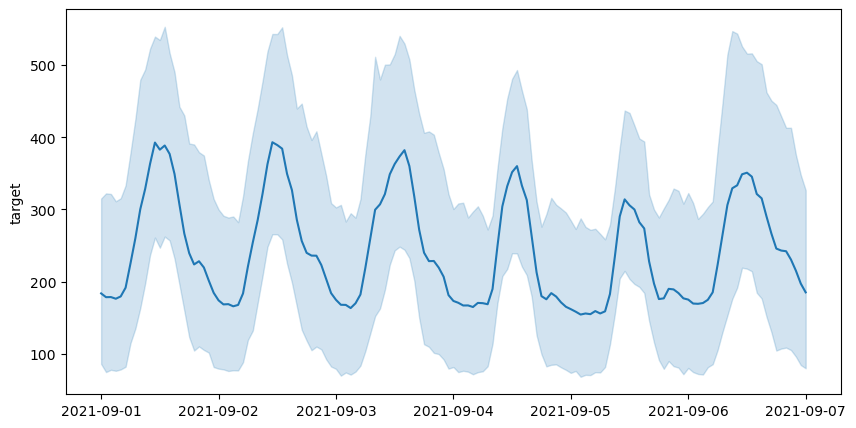

In [7]:
# 放大到一个星期
train_week = train_show.loc[pd.date_range('2021-9-1', '2021-9-7', freq='H')]
plt.figure(figsize=(10, 5))
sns.lineplot(x=train_week.index, y=train_week['target'])

<Axes: ylabel='target'>

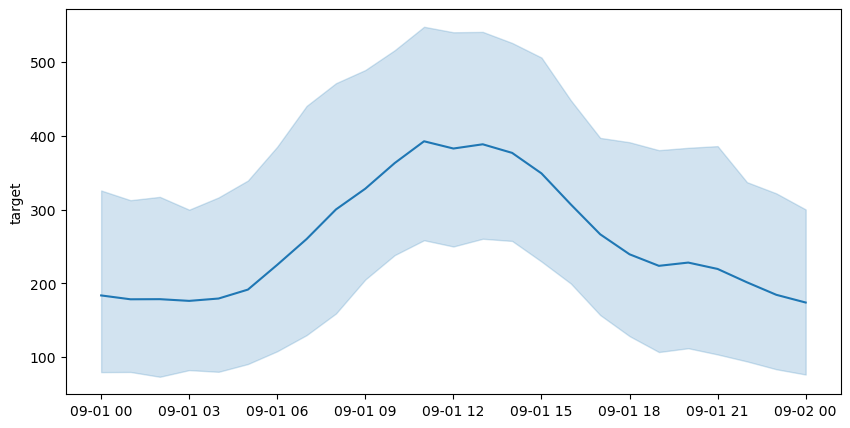

In [8]:
# 放大到一天
train_day = train_show.loc[pd.date_range('2021-9-1', '2021-9-2', freq='H')]
plt.figure(figsize=(10, 5))
sns.lineplot(x=train_day.index, y=train_day['target'])

## Generate train and test data

In [9]:
# define some funtions
def split_date(data: DataFrame, col: str):
    """
    拆分时间
    :param data:需要拆分的数据
    :param col: 时间所在的列
    :return: DataFrame
    """
    data['year'] = data[col].apply(lambda x: x.year)
    data['month'] = data[col].apply(lambda x: x.month)
    data['day'] = data[col].apply(lambda x: x.day)
    data['hour'] = data[col].apply(lambda x: x.hour)
    return data

def structure_time(data, date_col, target_col, day):
    """构造时间位移函数"""
    data_new = data.copy()
    data_new[date_col] = data_new[date_col] + pd.Timedelta(day, 'D')
    data_new.rename(columns={target_col: target_col+'_'+str(day)}, inplace=True)
    return data_new


def merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station):
    """处理train数据"""
    if 'datetime' in train.columns:
        pass
    else:
        train.rename(columns={'prediction_datetime': 'datetime'}, inplace=True)
    train = split_date(train, 'datetime')  # 拆分时间

    """构造target 2、3、4、5、6、7、14天数据"""
    target2 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 2)
    target3 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 3)
    target4 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 4)
    target5 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 5)
    target6 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 6)
    target7 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                             'datetime', 'target', 7)
    target14 = structure_time(train_history[['datetime', 'county', 'is_business', 'product_type', 'is_consumption', 'target']],
                              'datetime', 'target', 14)

    """构造target过去第2天的均值，按county取平均"""
    target_mean = target2.groupby(by=['datetime', 'is_business', 'product_type', 'is_consumption']).mean()['target_2']
    target_mean.rename('target_mean', inplace=True)

    """处理client数据"""
    client['datetime'] = client['date'].apply(lambda x: x+pd.Timedelta(2, 'D'))  # 将day向前移两天
    client = split_date(client, 'datetime')
    client.drop(columns=['hour', 'datetime', 'date'], inplace=True)

    """处理gas_prices数据"""
    gas_prices['datetime'] = gas_prices['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    gas_prices = split_date(gas_prices, 'datetime')
    gas_prices.drop(columns=['datetime', 'forecast_date', 'hour'], inplace=True)

    """处理electricity数据"""
    electricity['datetime'] = electricity['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    electricity.drop(columns=['forecast_date'], inplace=True)

    """处理historical_weather数据"""
    historical_weather['datetime'] = historical_weather['datetime'].apply(lambda x: x + pd.Timedelta(37, 'H'))
    historical_weather['latitude'] = historical_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    historical_weather['longitude'] = historical_weather['longitude'].astype(float)
    historical_weather.loc[:, 'latitude'] = historical_weather.loc[:, 'latitude'].round(1)   # 将经纬度取一位小数
    historical_weather.loc[:, 'longitude'] = historical_weather.loc[:, 'longitude'].round(1)
    station['latitude'] = station['latitude'].astype(float)
    station['longitude'] = station['longitude'].astype(float)
    station.loc[:, 'longitude'] = station.loc[:, 'longitude'].round(1)
    station.loc[:, 'latitude'] = station.loc[:, 'latitude'].round(1)
    # 与station数据按照经纬度和时间拼接
    historical_weather = pd.merge(left=historical_weather, right=station, how='left', on=['latitude', 'longitude'])
    # historical_weather.dropna(subset='county', inplace=True)
    historical_weather.drop(columns=['latitude', 'longitude'], inplace=True)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    historical_weather_local = historical_weather.groupby(by=['datetime', 'county']).mean()

    """构造全局天气均值"""
    historical_weather_date = historical_weather[['datetime', 'temperature', 'dewpoint', 'snowfall', 'cloudcover_total',
                                                  'cloudcover_low', 'shortwave_radiation', 'direct_solar_radiation',
                                                  'diffuse_radiation']].groupby(by=['datetime']).mean()
    col_new = {}
    for col in historical_weather_date.columns:
        col_new[col] = col + '_global'
    historical_weather_date.rename(columns=col_new, inplace=True)

    """处理forecast_weather数据"""
    forecast_weather = forecast_weather[forecast_weather['hours_ahead'] >= 24]
    forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)
    forecast_weather.loc[:, 'longitude'] = forecast_weather.loc[:, 'longitude'].round(1)
    forecast_weather.loc[:, 'latitude'] = forecast_weather.loc[:, 'latitude'].round(1)
    forecast_weather = pd.merge(left=forecast_weather, right=station, on=['latitude', 'longitude'])
    # 去除缺失值以及删除无用列
    # forecast_weather.dropna(subset='county', inplace=True)
    forecast_weather.drop(
        columns=['latitude', 'longitude', 'hours_ahead'],
        inplace=True)
    # 将forecast列索引重命名，以防止合并后与historical重名
    forecast_cols_new = {}
    forecast_cols = forecast_weather.columns
    for index in forecast_cols:
        if index == 'forecast_datetime':
            index_new = 'datetime'
        elif index == 'county':
            index_new = index
        else:
            index_new = str(index) + '_fw'
        forecast_cols_new[index] = index_new
    forecast_weather.rename(columns=forecast_cols_new, inplace=True)
    # 去除时间UTC值
    forecast_weather['datetime'] = pd.to_datetime(forecast_weather.datetime).dt.tz_localize(None)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    forecast_weather = forecast_weather.groupby(by=['datetime', 'county']).mean()

    """开始拼接数据"""
    data = reduce(lambda left, right: pd.merge(left, right, how='left',
                  on=['datetime', 'county', 'is_business', 'product_type', 'is_consumption']),
                  [train, target2, target3, target4, target5, target6, target7, target14])
    data = pd.merge(left=data, right=target_mean, how='left', on=['datetime', 'is_business',
                                                                  'product_type', 'is_consumption'])
    data = pd.merge(left=data, right=client, how='left', on=['product_type', 'county',
                                                             'is_business', 'year', 'month', 'day'])
    data = pd.merge(left=data, right=gas_prices, how='left', on=['year', 'month', 'day'])
    data = pd.merge(left=data, right=electricity, how='left', on='datetime')
    data = pd.merge(left=data, right=historical_weather_local, how='left', on=['datetime', 'county'])
    data = pd.merge(left=data, right=historical_weather_date, how='left', on=['datetime'])
    data = pd.merge(left=data, right=forecast_weather, how='left', on=['datetime', 'county'])

    return data

def load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station, is_train=True):
    """加载数据"""
    data = merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station)
    # 删除多余列
    data.drop(columns=['datetime'], inplace=True)
    # one-hot编码
    data = pd.get_dummies(data, columns=['is_business', 'product_type', 'is_consumption'], dtype=float)
    # 生成nparray数组
    if is_train:
        # 删除缺失值
        data.dropna(subset=['target'], inplace=True)
        X = data.drop(columns=['row_id', 'target'])
        features = list(X.columns)
        X = np.array(X)
        Y = data['target']
        Y = np.array(Y)
        output = (features, X, Y)
        with open("train_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    else:
        X = data.drop(columns=['row_id'])
        X = np.array(X)
        output = X
        with open("test_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    return output

def make_train_test(X, Y, seed, rate):
    """划分训练集和测试集，并且打乱"""
    idx = int(rate * X.shape[0])
    X_train = X[:idx]
    Y_train = Y[:idx]
    X_test = X[idx:]
    Y_test = Y[idx:]
    shuffled_indices = np.arange(X_train.shape[0])
    np.random.seed(seed)
    np.random.shuffle(shuffled_indices)
    X_train, Y_train = X_train[shuffled_indices], Y_train[shuffled_indices]
    return (X_train, Y_train), (X_test, Y_test)

In [10]:
# 未筛选特征所用到的列
train_cols = ['county', 'target', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
test_cols = ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_datetime', 'row_id']
train_history_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
station_cols = ['longitude', 'latitude', 'county']

In [12]:
# 生成未筛选训练数据
train = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'], usecols=train_cols)
train_history = pd.read_csv(os.path.join(root_path, 'train.csv'), parse_dates=['datetime'], usecols=train_history_cols)
client = pd.read_csv(os.path.join(root_path, 'client.csv'), parse_dates=['date'], usecols=client_cols)
gas_prices = pd.read_csv(os.path.join(root_path, 'gas_prices.csv'), parse_dates=['forecast_date'], usecols=gas_cols)
electricity = pd.read_csv(os.path.join(root_path, 'electricity_prices.csv'), parse_dates=['forecast_date'], usecols=electricity_cols)
historical_weather = pd.read_csv(os.path.join(root_path, 'historical_weather.csv'), parse_dates=['datetime'],
                                     usecols=historical_cols)
forecast_weather = pd.read_csv(os.path.join(root_path, 'forecast_weather.csv'), parse_dates=['forecast_datetime'],
                                   usecols=forecast_cols)
station = pd.read_csv(os.path.join(root_path, 'weather_station_to_county_mapping.csv'), usecols=station_cols)
features, X, Y = load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station)
# 划分训练集和测试集
(X_train, y_train), (X_test, y_test) = make_train_test(X, Y, 1, 0.7)
print('features:', features)

C:\Users\zhongchen\AppData\Local\Temp\ipykernel_25584\2460010645.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
C:\Users\zhongchen\AppData\Local\Temp\ipykernel_25584\2460010645.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)


features: ['county', 'year', 'month', 'day', 'hour', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_14', 'target_mean', 'eic_count', 'installed_capacity', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'temperature_global', 'dewpoint_global', 'snowfall_global', 'cloudcover_total_global', 'cloudcover_low_global', 'shortwave_radiation_global', 'direct_solar_radiation_global', 'diffuse_radiation_global', 'temperature_fw', 'dewpoint_fw', 'cloudcover_high_fw', 'cloudcover_low_fw', 'cloudcover_mid_fw', 'cloudcover_total_fw', '10_metre_u_wind_component_fw', '10_metre_v_wind_component_fw', 'direct_solar_radiation_fw', 'surface_solar_radiation_downwards_fw', 'snowfall_fw', 'total_precipitation_fw',

# Model

In [13]:
class Xgb:
    def __init__(self):
        self.model = xgb.XGBRegressor(
                        objective='reg:absoluteerror',
                        n_estimators = 2 if False else 1500,
                        early_stopping_rounds=100
                        )

    def fit(self, X, y, X_test, y_test):
        """训练"""
        self.model.fit(X = X, y = y, eval_set = [(X, y), (X_test, y_test)],verbose = False)
        # print(f'Early stopping on best iteration #{self.model.best_iteration} with MAE error on validation set of {self.model.best_score:.2f}')
        y_pred = self.model.predict(X_test)
        print("mean_absolute_error in test set:", mean_absolute_error(y_pred, y_test))
        
    def predict(self, X):
        """预测"""
        output = self.model.predict(X)
        return  output
    
    def importance(self, features, max_num):
        """特征重要性"""
        self.model.get_booster().feature_names = features
        plot_importance(self.model, max_num_features=max_num)
        plt.show()

        
class LightGBM:
    def __init__(self):
        self.model = lgb.LGBMRegressor(objective='regression', n_estimators=100)

    def fit(self, X_train, y_train, X_test, y_test, features):
        self.model.fit(X_train, y_train, feature_name=features)
        y_pred = self.model.predict(X_test)
        print("mean_absolute_error in test set:", mean_absolute_error(y_pred, y_test))
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        return y_pred

    def importance(self, max_num):
        lgb.plot_importance(self.model, max_num_features=max_num)
        plt.show()

# Train

## Train  LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.975275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11915
[LightGBM] [Info] Number of data points in the train set: 1412476, number of used features: 60
[LightGBM] [Info] Start training from score 251.177369
mean_absolute_error in test set: 62.15902936778924


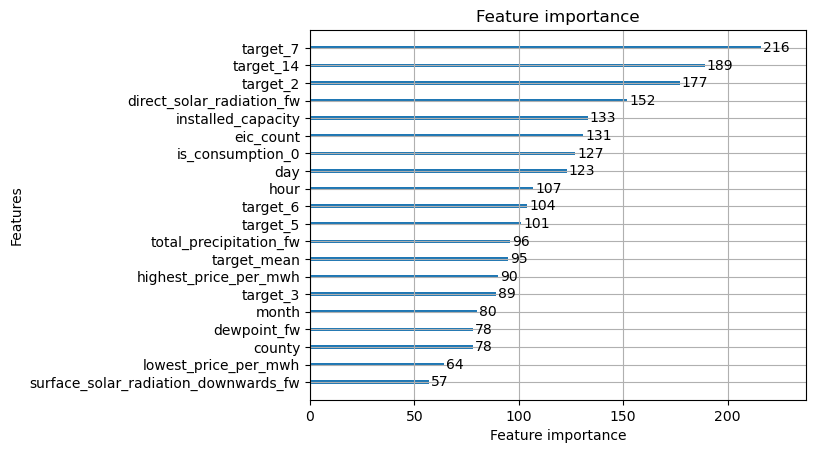

In [14]:
model = LightGBM()
model.fit(X_train, y_train, X_test, y_test, features)
model.importance(max_num=20)

## Train XGboost

mean_absolute_error in test set: 64.56613661423266


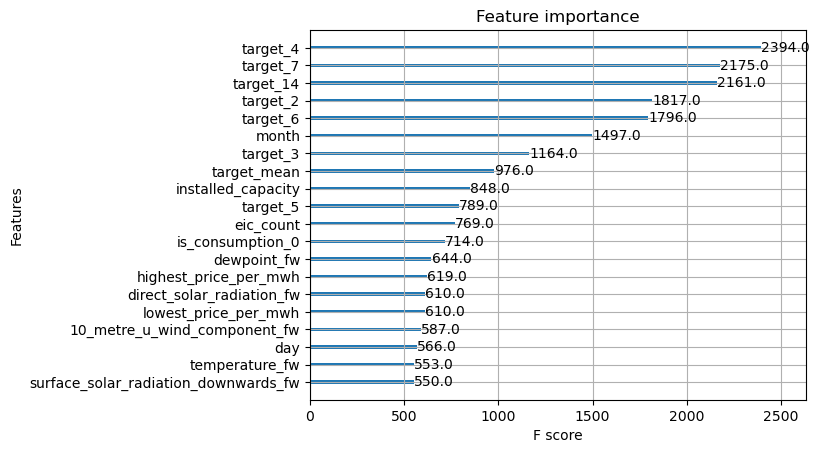

In [15]:
model_xg = Xgb()
model_xg.fit(X_train, y_train, X_test, y_test)
model_xg.importance(features, max_num=20)

## Comparison between two models
Using MAE

In [19]:
score = pd.DataFrame({'using original features': [92, 90.96], 'using new features': [62.16, 64.57], 'kaggle score': [85, 122]}, 
                    index=['LightGBM', 'XGboost'])
score

,using original features,using new features,kaggle score
LightGBM,92.00,62.16,85
XGboost,90.96,64.57,122


# Predict

# 导入api
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    test = test[test_cols]
    revealed_targets = revealed_targets[train_history_cols]
    # 将已有的train_history与api给的revealed_targets拼接，不然无法得到3、4、5、6、7、14天历史target
    train_history = pd.concat([train_history, revealed_targets]).drop_duplicates(ignore_index=True)
    client = client[client_cols]
    historical_weather = historical_weather[historical_cols]
    forecast_weather = forecast_weather[forecast_cols]
    electricity_prices = electricity_prices[electricity_cols]
    gas_prices = gas_prices[gas_cols]
    station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv', 
                          usecols=station_cols)
    X= load_data(test, train_history, client, gas_prices, electricity_prices,
                             historical_weather, forecast_weather, station, is_train=False)
    target = model.predict(X)
    sample_prediction['target'] = target
    # print(sample_prediction)
    # 提交
    env.predict(sample_prediction)